In [289]:
import os, shutil
import warnings
import pathlib
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [290]:
base_dir = '/home/kailash/VScode Python projects/tf/conv/small_dataset/'

In [291]:
train_dir = os.path.join(base_dir,'train')

validation_dir = os.path.join(base_dir, 'validation')

test_dir = os.path.join(base_dir, 'test')

In [292]:
import tensorflow as tf

In [293]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [294]:
import tensorflow as tf
from tensorflow import keras


In [295]:
train_dir = pathlib.Path(train_dir)

In [296]:
train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'), shuffle=False)

In [297]:
validation_dir = pathlib.Path(validation_dir)

In [298]:
val_ds = tf.data.Dataset.list_files(str(validation_dir/'*/*'), shuffle=False)

In [299]:
train_ds

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [300]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == ['cats','dogs']
  # Integer encode the label
  return tf.argmax(one_hot)

In [301]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [150, 150])

In [302]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [303]:
AUTOTUNE = tf.data.AUTOTUNE

In [304]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [305]:
IMG_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
   tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
   tf.keras.layers.Rescaling(1./255)
])

In [306]:
data_augmentation = tf.keras.Sequential([
   tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomTranslation(.2,.2),
  tf.keras.layers.RandomZoom(.2)
])
 

In [307]:
train_ds


<ParallelMapDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [308]:
batch_size = 10


def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [309]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)


In [310]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [311]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32,(3,3),padding = "same",activation="relu",input_shape=(150,150,3)))
model.add(tf.keras.layers.MaxPooling2D((2,3)))
model.add(tf.keras.layers.Conv2D(64, (3, 3),padding = "same", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = "same",activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = "same",activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [312]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 75, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 75, 50, 64)        18496     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 37, 25, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 37, 25, 128)       73856     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 18, 12, 128)    

In [313]:

model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4,decay=1e-6),metrics=['acc'])

In [314]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("cats_dog",save_best_only=True)

In [315]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [316]:
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)


run_logdir = get_run_logdir()


In [317]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [318]:
history = model.fit(train_ds,epochs=100,validation_data=val_ds,callbacks=[early_stopping_cb,tensorboard_cb])

Epoch 1/100
200/200 [==============================] - 11s 42ms/step - loss: 0.6531 - acc: 0.6150 - val_loss: 0.7241 - val_acc: 0.5000
Epoch 2/100
200/200 [==============================] - 9s 40ms/step - loss: 0.6675 - acc: 0.5940 - val_loss: 0.7758 - val_acc: 0.5000
Epoch 3/100
200/200 [==============================] - 9s 40ms/step - loss: 0.6841 - acc: 0.5765 - val_loss: 0.7212 - val_acc: 0.5000
Epoch 4/100
200/200 [==============================] - 8s 36ms/step - loss: 0.6730 - acc: 0.5790 - val_loss: 0.7075 - val_acc: 0.5000
Epoch 5/100
200/200 [==============================] - 8s 39ms/step - loss: 0.6895 - acc: 0.5195 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 6/100
200/200 [==============================] - 8s 37ms/step - loss: 0.6937 - acc: 0.4915 - val_loss: 0.6929 - val_acc: 0.4990
Epoch 7/100
200/200 [==============================] - 8s 38ms/step - loss: 0.6899 - acc: 0.5250 - val_loss: 0.7007 - val_acc: 0.4990
Epoch 8/100
200/200 [==============================] - 8s 39m

In [319]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [320]:
import pandas as pd
import matplotlib.pyplot as plt

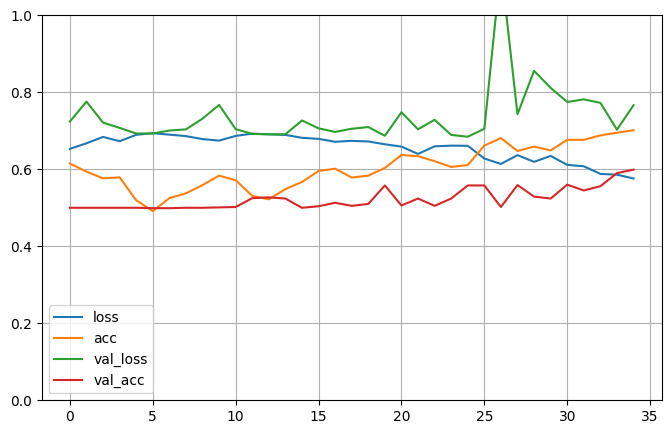

In [321]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [322]:
# model.save("cats_and_dogs")

In [323]:
!tensorboard --bind_all --logdir=./my_logs --port=6006

/bin/bash: /home/kailash/anaconda3/envs/tensorflow1/lib/libtinfo.so.6: no version information available (required by /bin/bash)

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.10.0 at http://kailash-ASUS-TUF-Gaming-A17-FA706IC-FA766IC:6006/ (Press CTRL+C to quit)
W0921 12:43:54.292877 139896970794560 security_validator.py:46] In 3.0, this warning will become an error:
Illegal Content-Security-Policy for script-src: 'unsafe-inline'
W0921 12:43:55.062223 139896480069184 security_validator.py:46] In 3.0, this warning will become an error:
Illegal Content-Security-Policy for script-src: 'unsafe-inline'
W0921 12:43:57.852058 139896480069184 application.py:558] path /data/plugin/profile not found, sending 404
W0921 12:43:57.881579 139896480069184 application.py:558] path /data/plugin/profile/overview_page@;run=run_2022_09_20-15_20_37/